## SOTA: Cellpose-SAM (Segment Anything)

In [ ]:
# !pip install cellpose scikit-image

Tiling script from other notebooks copied here with modifications for 'filled-in' *and labeled* masks that are >0 on a black background.

/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_0_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_1_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_2_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_3_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_4_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_5_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3

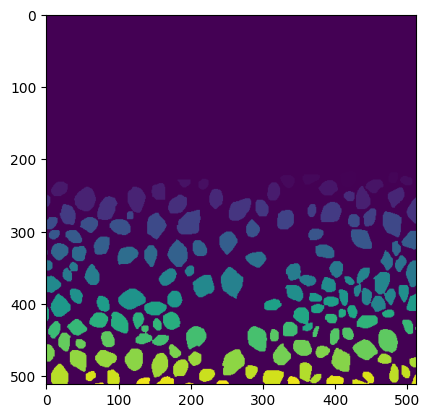

/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_16_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_17_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_18_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_19_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_20_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_1_21_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/p

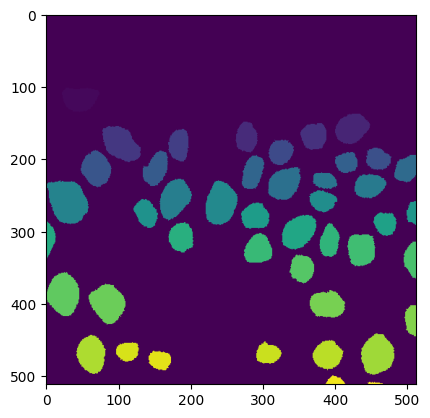

/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_2_16_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_2_17_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_2_18_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_2_19_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_2_20_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: tiles/tile_2_21_masks.tif is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/p

In [ ]:
!mkdir -p tiles/images tiles/masks

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import io as skio
from skimage.color import rgb2gray
from skimage.measure import label
from sklearn.metrics import jaccard_score
from skimage.io import imsave

from scipy.ndimage import label


TILE_SIZE, OVERLAP = 512, 128 # 512x512 tiles

for i in range(1, 3):
    path0 = f'data/img{i}.png'
    path1 = f'data/mask{i}.png'

    image = cv2.imread(path0, cv2.IMREAD_UNCHANGED)

    # Convert outlines mask to white outlines with black background
    mask = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
    mask = cv2.adaptiveThreshold(mask, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 1)
    mask = cv2.bitwise_not(mask)

    kernel = np.ones((2, 2), np.uint8)
    # thicker = cv2.dilate(mask, kernel, iterations=1)

    # Morphological closing to seal small holes and gaps
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Flood fill from corners
    floodfilled = closed.copy()
    h, w = closed.shape
    mask_ff = np.zeros((h + 2, w + 2), np.uint8)
    for seed in [(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)]:
        cv2.floodFill(floodfilled, mask_ff, seed, 255)

    floodfilled_inv = cv2.bitwise_not(floodfilled)
    mask = cv2.bitwise_or(closed, floodfilled_inv)

    # # Save filled-in binary masks also
    # cv2.imwrite(os.path.join('data', f'mask{i}_filled.png'), mask)

    height, width = image.shape[:2]
    j = 0
    for top in range(0, height - TILE_SIZE + 1, OVERLAP):
        for left in range(0, width - TILE_SIZE + 1, OVERLAP):
            tile0 = image[top : top + TILE_SIZE, left : left + TILE_SIZE]
            tile1 = mask[top : top + TILE_SIZE, left : left + TILE_SIZE]

            labeled_tile, n = label(tile1 > 0)
            if n < 1: continue

            # Ignore tiles that are 90% black (empty)
            if (np.sum(tile1 < 5)) / (TILE_SIZE ** 2) > 0.90:
                continue

            if j == 16: # just make sure we get the right labeled masks
              plt.imshow(labeled_tile)
              plt.show()

            cv2.imwrite(os.path.join('tiles/', f"tile_{i}_{j}.png"), tile0)
            imsave(f'tiles/tile_{i}_{j}_masks.tif', labeled_tile.astype(np.uint16))

            j += 1




Cellpose (which runs on Segment Anything) expects labeled masks for training.

I began with a [large dataset of nuclei](https://monusac-2020.grand-challenge.org/) which I intended to Progressively Fine-Tune with the jagged elliptical outlines of nuclei on a ResNet backbone which already recognized shapes, blobs and outlines due to pretraining on the large Imagenet dataset, but performed poorly on the barnacle dataset without fine-tuning. Then I began to fine-tune on a smaller dataset tiled dataset of barnacles (made from the two annotated images given to us) with a very small learning rate to avoid catastrophic forgetting.

I found Cellpose had been trained on large nuclei and cell datasets already, so the first step in this PFT approach was done for me. I trian with larger tiles here since Cellpose is shown to perform better on small masks in large images.

We were provided with blue outlines that sometimes had incomplete ellipses, which makes flood-fill harder. So:
1. Try and morphologically close the holes with a relatively smaller kernel because barnacle outlines in first image are qutie small.
2. Flood fill from the corners in first so that the open outlines don't overflow into the background.

In [ ]:
# !mv -r mtiles tiles

Set up the relatively simple training script below:

In [ ]:
from cellpose import io, models, train, plot

io.logger_setup()

output = io.load_train_test_data('tiles', None, image_filter="", mask_filter="_masks", look_one_level_down=False)
images, labels, image_names, test_images, test_labels, image_names_test = output

model = models.CellposeModel(gpu=True, model_type='cpsam') # Thank god for Colab

# Small learning rate performs well enough since edge detection from nuclei segmentation
# is quite powerful already.
model_path, losses, _ = train.train_seg(model.net, train_data=images, train_labels=labels, weight_decay=0.1, learning_rate=1e-5, n_epochs=10, model_name="barn0")

2025-07-28 20:26:16,624 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-07-28 20:26:16,624 [INFO] 
cellpose version: 	4.0.6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-07-28 20:26:16,648 [INFO] not all flows are present, running flow generation for all images
2025-07-28 20:26:19,049 [INFO] 283 / 283 images in tiles folder have labels
2025-07-28 20:26:19,050 [WARNING] model_type argument is not used in v4.0.1+. Ignoring this argument...
2025-07-28 20:26:19,051 [INFO] ** TORCH CUDA version installed and working. **
2025-07-28 20:26:19,051 [INFO] >>>> using GPU (CUDA)
2025-07-28 20:26:21,684 [INFO] >>>> loading model /root/.cellpose/models/cpsam
2025-07-28 20:26:22,311 [INFO] computing flows for labels


100%|██████████| 283/283 [00:17<00:00, 16.01it/s]

2025-07-28 20:26:40,154 [INFO] >>> computing diameters



100%|██████████| 283/283 [00:00<00:00, 808.75it/s]

2025-07-28 20:26:40,507 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-07-28 20:26:44,956 [INFO] >>> n_epochs=10, n_train=283, n_test=None
2025-07-28 20:26:44,957 [INFO] >>> AdamW, learning_rate=0.00001, weight_decay=0.10000
2025-07-28 20:26:44,960 [INFO] >>> saving model to /content/models/barn0
2025-07-28 20:27:23,841 [INFO] 0, train_loss=4.0770, test_loss=0.0000, LR=0.000000, time 38.88s
2025-07-28 20:30:38,383 [INFO] 5, train_loss=3.5356, test_loss=0.0000, LR=0.000006, time 233.42s
2025-07-28 20:33:13,615 [INFO] saving network parameters to /content/models/barn0


Can't calculate Dice and IoU accurately since we have outlined annotations versus instance segments, but instance segmentation seems good on comparision.

Run on img1.png and compare with masked version.

2025-07-28 21:33:18,000 [INFO] ** TORCH CUDA version installed and working. **
2025-07-28 21:33:18,001 [INFO] >>>> using GPU (CUDA)
2025-07-28 21:33:20,332 [INFO] >>>> loading model /content/models/barn0


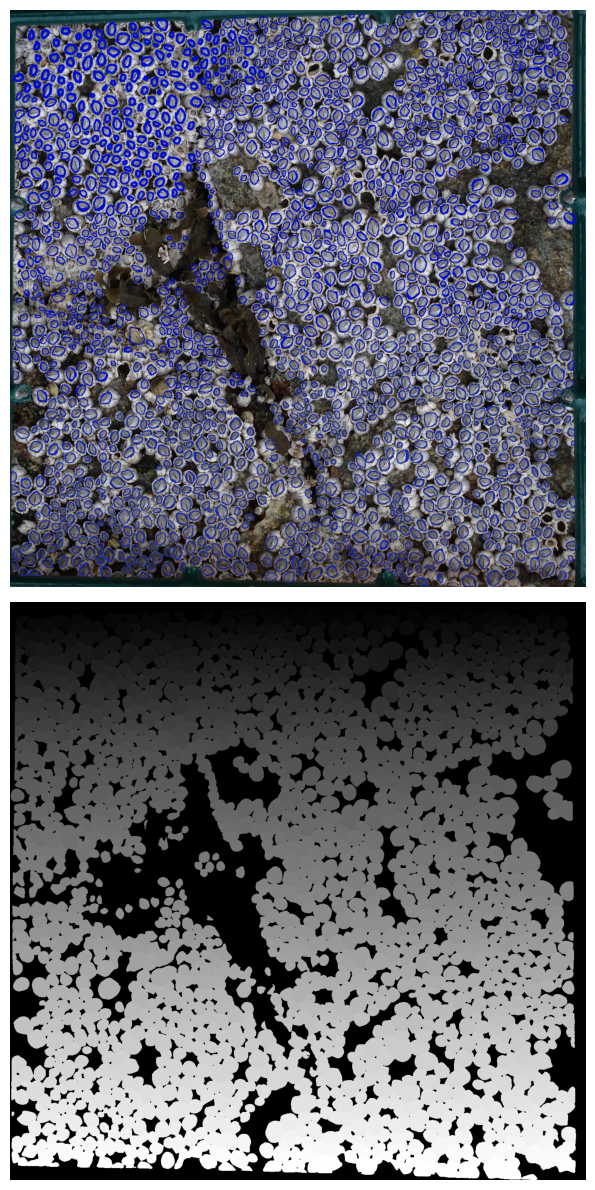

Barnacles in img1.png: 1880


In [ ]:
# Load pretrained weights
model = models.CellposeModel(gpu=True, pretrained_model='/content/models/barn0')

image, overlaid = io.imread("data/img1_cropped.png"), io.imread("data/img1_masked.png")

masks, _, _ = model.eval(image)
rgb_mask = plot.image_to_rgb(masks)

fig, axes = plt.subplots(2, 1, figsize=(10, 12))

axes[0].imshow(overlaid, cmap='gray')
axes[0].axis('off')

axes[1].imshow(rgb_mask, cmap='gray')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print('Barnacles in img1.png:', len(np.unique(masks)))

And run it on unseen images.

Barnacles in unsene_img1.png: 1364
Barnacles in unseen_img2.png: 158


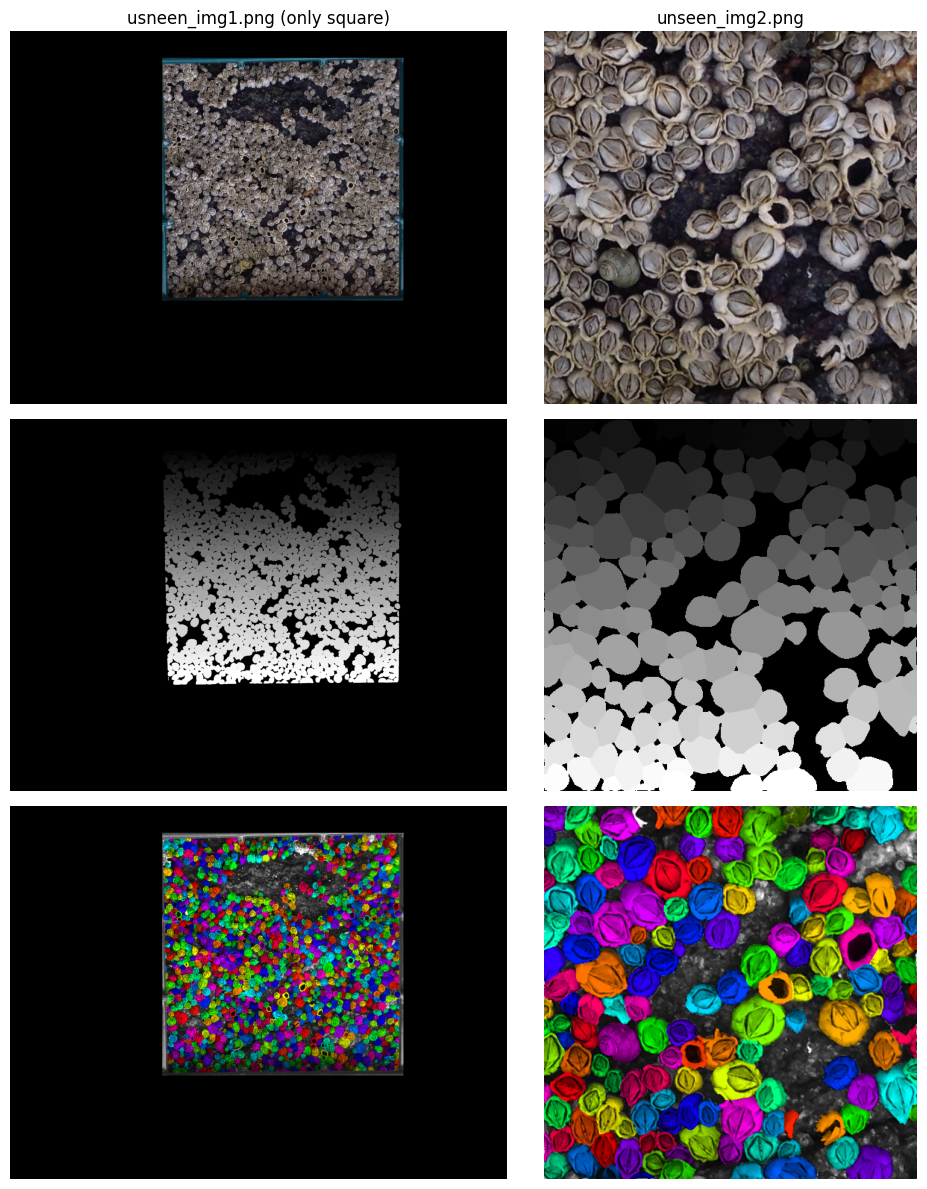

In [ ]:
unseen1 = io.imread("unseen_img1_nice.png")
unseen2 = io.imread("unseen_img2.png")

masks1, _, _ = model.eval(unseen1)
masks2, _, _ = model.eval(unseen2)

rgb_mask1 = plot.image_to_rgb(masks1)
rgb_mask2 = plot.image_to_rgb(masks2)

overlay1 = plot.mask_overlay(unseen1, masks1)
overlay2 = plot.mask_overlay(unseen2, masks2)

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Originalws
axes[0, 0].imshow(unseen1, cmap='gray')
axes[0, 0].set_title("usneen_img1.png (only square)")
axes[0, 0].axis('off')

axes[0, 1].imshow(unseen2, cmap='gray')
axes[0, 1].set_title("unseen_img2.png")
axes[0, 1].axis('off')

# Masks
axes[1, 0].imshow(rgb_mask1)
axes[1, 0].axis('off')

axes[1, 1].imshow(rgb_mask2)
axes[1, 1].axis('off')

# Overlays
axes[2, 0].imshow(overlay1)
axes[2, 0].axis('off')

axes[2, 1].imshow(overlay2)
axes[2, 1].axis('off')

print('Barnacles in unsene_img1.png:', len(np.unique(masks1)))
print('Barnacles in unseen_img2.png:', len(np.unique(masks2)))

plt.tight_layout()
plt.show()